# Sentiment Classification

### Task
* IMDB 영화사이트에서 50000개의 영화평을 가지고 positive/negative인지 구분해보자.
* 데이터 불러오기를 제외한 딥러닝 트레이닝 과정을 직접 구현해보는 것이 목표 입니다.

### Dataset
* [IMDB datasets](https://www.imdb.com/interfaces/)

### Base code
* Dataset: train, val, test로 split
* Input data shape: (`batch_size`, `max_sequence_length`)
* Output data shape: (`batch_size`, 1)
* Architecture:
  * RNN을 이용한 간단한 classification 모델 가이드
  * `Embedding` - `SimpleRNN` - `Dense (with Sigmoid)`
  * [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 사용
* Training
  * `model.fit` 사용
* Evaluation
  * `model.evaluate` 사용 for test dataset

### Try some techniques
* Training-epochs 조절
* Change model architectures (Custom model)
  * Use another cells (LSTM, GRU, etc.)
  * Use dropout layers
* Embedding size 조절
  * 또는 one-hot vector로 학습
* Number of words in the vocabulary 변화
* `pad` 옵션 변화
* Data augmentation (if possible)

## 자연어처리에 관한 work flow

The flowchart of the algorithm is roughly:

<img src="https://user-images.githubusercontent.com/11681225/46912373-d2a3a800-cfae-11e8-8201-ef17b65834f5.png" alt="natural_language_flowchart" style="width: 300px;"/>

## Import modules

In [32]:
use_colab = True
assert use_colab in [True, False]

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

from tensorflow.keras import layers

## Load Data

* IMDB에서 다운받은 총 50000개의 영화평을 사용한다.
* `tf.keras.datasets`에 이미 잘 가공된 데이터 셋이 있으므로 쉽게 다운받아 사용할 수 있다.
* 원래는 text 데이터이지만 `tf.keras.datasets.imdb`는 이미 Tokenizing이 되어있다.

In [35]:
# Load training and eval data from tf.keras
imdb = tf.keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
train_labels = train_labels.astype(np.float64)
test_labels = test_labels.astype(np.float64)

In [37]:
print("Train-set size: ", len(train_data))
print("Test-set size:  ", len(test_data))
print('Classes:',len(set(train_labels)))

Train-set size:  25000
Test-set size:   25000
Classes: 2


### Data 출력
* 데이터셋을 바로 불러왔을때 출력되는 데이터를 확인해보자

In [42]:
print(train_data[0])
print(len(train_data[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218


In [7]:
print("sequence length: {}".format(len(train_data[1])))

sequence length: 189


max length: 2494
min length: 11


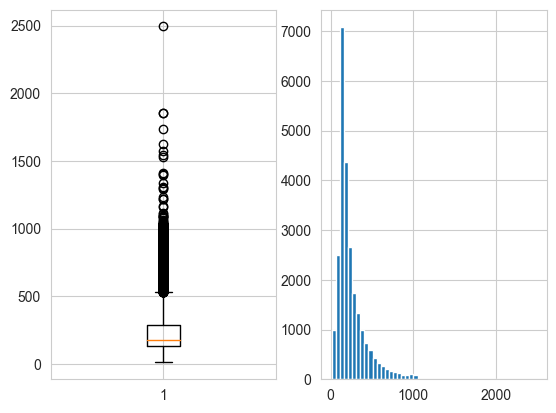

In [47]:
reviews_length = [len(review) for review in train_data]
print("max length: {}".format(np.max(reviews_length)))
print("min length: {}".format(np.min(reviews_length)))

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.boxplot(reviews_length)
plt.subplot(1,2,2)
plt.hist(reviews_length, bins=50)
plt.show()

* Label정보를 확인해보자
  * 0.0 for a negative sentiment 부정적인 리뷰
  * 1.0 for a positive sentiment 긍정적인 리뷰

In [52]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print("레이블 빈도수:")
print(unique_elements, counts_elements)
print(np.asarray((unique_elements, counts_elements)).astype(int)) # 정수로만 나오게 수정

레이블 빈도수:
[0. 1.] [12500 12500]
[[    0     1]
 [12500 12500]]


In [63]:
# negative sample
index = 1
print("text: {}\n".format(train_data[index]))
print("label: {}".format(train_labels[index]))

text: [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]

label: 0.0


In [64]:
# positive sample
index = 200
print("text: {}\n".format(train_data[index]))
print("label: {}".format(train_labels[index]))

text: [1, 14, 9, 6, 227, 196, 241, 634, 891, 234, 21, 12, 69, 6, 6, 176, 7, 4, 804, 4658, 2999, 667, 11, 12, 11, 85, 715, 6, 176, 7, 1565, 8, 1108, 10, 10, 12, 16, 1844, 2, 33, 211, 21, 69, 49, 2009, 905, 388, 99, 2, 125, 34, 6, 2, 1274, 33, 4, 130, 7, 4, 22, 15, 16, 6424, 8, 650, 1069, 14, 22, 9, 44, 4609, 153, 154, 4, 318, 302, 1051, 23, 14, 22, 122, 6, 2093, 292, 10, 10, 723, 8721, 5, 2, 9728, 71, 1344, 1576, 156, 11, 68, 251, 5, 36, 92, 4363, 133, 199, 743, 976, 354, 4, 64, 439, 9, 3059, 17, 32, 4, 2, 26, 256, 34, 2, 5, 49, 7, 98, 40, 2345, 9844, 43, 92, 168, 147, 474, 40, 8, 67, 6, 796, 97, 7, 14, 20, 19, 32, 2188, 156, 24, 18, 6090, 1007, 21, 8, 331, 97, 4, 65, 168, 5, 481, 53, 3084]

label: 1.0


## Prepare dataset

### Convert the integers back to words

* 실제 우리가 다루고 있는 데이터가 진짜 리뷰데이터인지 확인해보자

In [66]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
# 수동으로 설정해줌.
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [67]:
len(word_index)

88588

#### Text data 출력

In [68]:
print(train_data[5])
len(train_data)

[1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 7982, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]


25000

In [13]:
decode_review(train_data[5])

"<START> begins better than it ends funny that the russian submarine crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br"

In [14]:
print(train_labels[5])

0.0


### Padding and truncating data using pad sequences
* 전부 길이가 다른 리뷰들의 길이를 통일해주자

In [15]:
from tensorflow.keras.utils import pad_sequences

In [16]:
num_seq_length = np.array([len(tokens) for tokens in list(train_data) + list(test_data)])
train_seq_length = np.array([len(tokens) for tokens in train_data], dtype=np.int32)
test_seq_length = np.array([len(tokens) for tokens in test_data], dtype=np.int32)
print(len(train_seq_length))

25000


In [17]:
max_seq_length = 728

* Max length보다 작은 리뷰의 퍼센트

In [18]:
print(np.sum(num_seq_length < max_seq_length) / len(num_seq_length))

0.97304


* `max_seq_length`을 256으로 설정하면 전체 데이터 셋의 70%를 커버할 수 있다.
* 30% 정도의 데이터가 256 단어가 넘는 문장으로 이루어져 있다.
* 보통 미리 정한 `max_seq_length`를 넘어가는 문장의 데이터는 *truncate* 한다.

In [19]:
# padding 옵션은 두 가지가 있다.
pad = 'pre'
# pad = 'post'

In [20]:
train_data_pad = pad_sequences(train_data,
                               maxlen=max_seq_length,
                               padding=pad,
                               value=word_index["<PAD>"])
test_data_pad = pad_sequences(test_data,
                              maxlen=max_seq_length,
                              padding=pad,
                              value=word_index["<PAD>"])

In [21]:
print(train_data_pad.shape)
print(test_data_pad.shape)

(25000, 728)
(25000, 728)


#### Padding data 출력

In [22]:
index = 0
print("text: {}\n".format(decode_review(train_data[index])))
print("token: {}\n".format(train_data[index]))
print("pad: {}".format(train_data_pad[index]))

text: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised f

### Create a validation set

In [23]:


# num_val_data = int(0.1 * len(test_data_pad))
# val_data_pad = test_data_pad[:num_val_data]
# train_data_pad_partial = test_data_pad[num_val_data:]
# 
# val_labels = test_labels[:num_val_data]
# train_labels_partial = test_labels[num_val_data:]

In [24]:


num_val_data = int(0.1 * len(train_data_pad))
val_data_pad = train_data_pad[:num_val_data]
train_data_pad_partial = train_data_pad[num_val_data:]

val_labels = train_labels[:num_val_data]
train_labels_partial = train_labels[num_val_data:]

In [25]:
len(train_data_pad)

25000

### Dataset 구성

In [26]:
batch_size = 64

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pad_partial, train_labels_partial))
train_dataset = train_dataset.shuffle(10000).repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pad, test_labels))
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for valid
valid_dataset = tf.data.Dataset.from_tensor_slices((val_data_pad, val_labels))
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 728), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 728), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 728), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


## Setup hyper-parameters

In [27]:
# Set the hyperparameter set
max_epochs = 5
embedding_size = 16
rnn_units = 32
vocab_size = 10000

# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/sentimental/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'sentimental/exp1'

## Build the model
### Embedding layer

* embedding-layer는 전체 vocabulary의 갯수(num_words)로 이루어진 index가 `embedding_size`의 *dense vector* 로 변환되는 과정이다.

In [28]:
# model = tf.keras.Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size
#                                 ))
# 
# model.add(layers.LSTM(units=rnn_units, return_sequences=True, 
#                       recurrent_initializer='glorot_uniform'))
# model.add(layers.LSTM(units=rnn_units, return_sequences=True, 
#                       recurrent_initializer='glorot_uniform'))
# model.add(layers.LSTM(units=rnn_units, return_sequences=False, 
#                       recurrent_initializer='glorot_uniform'))
# # model.add(layers.GRU(units=rnn_units//8, return_sequences=False, stateful=True, recurrent_initializer='glorot_uniform'))
# 
# model.add(layers.Dense(1)) # 이진 분류! 0 or 1

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 예제 데이터 생성


# 입력 레이어
inputs = Input(shape=(None,))
# 임베딩 레이어
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size)(inputs)
# 양방향 LSTM 레이어
lstm_layer = Bidirectional(LSTM(rnn_units, return_sequences=True))(embedding_layer)
lstm_layer = Bidirectional(LSTM(rnn_units, return_sequences=True))(lstm_layer)
lstm_layer = Bidirectional(LSTM(rnn_units, return_sequences=True))(lstm_layer)
# Attention 레이어
attention = Attention()([lstm_layer, lstm_layer])
# 가중합 계산
context = tf.reduce_sum(attention * lstm_layer, axis=1)
# 출력 레이어
output = Dense(1)(context)

# 모델 생성
model = Model(inputs=inputs, outputs=output)


In [30]:


# model = tf.keras.Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size ))
# model.add(Bidirectional(LSTM(units=rnn_units, return_sequences=True,
#                              recurrent_initializer='glorot_uniform')))
# model.add(Bidirectional(LSTM(units=rnn_units, return_sequences=True,
#                              recurrent_initializer='glorot_uniform')))
# model.add(Bidirectional(LSTM(units=rnn_units, return_sequences=False
#                              ,
#                              recurrent_initializer='glorot_uniform')))
# 
# model.add(Dense(1))


In [31]:


# model = tf.keras.Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size ))
# model.add(LSTM(units=rnn_units, return_sequences=True,
#                              recurrent_initializer='glorot_uniform'))
# model.add(LSTM(units=rnn_units, return_sequences=True,
#                              recurrent_initializer='glorot_uniform'))
# model.add(LSTM(units=rnn_units, return_sequences=False
#                              ,
#                              recurrent_initializer='glorot_uniform'))
# 
# model.add(Dense(1))


In [ ]:

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, GlobalMaxPool1D,Dropout
from tensorflow.keras.models import Model,Sequential
from keras.layers import Convolution1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
# model.add(Bidirectional(LSTM(32, return_sequences = True)))
# model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1))
# model = Model(inputs=inputs, outputs=output)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 16)     160000      ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 64)     12544       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, None, 64)    24832       ['bidirectional[0][0]']          
 )                                                                                            

### Compile the model

In [33]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer=optimizer,
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [34]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     monitor='val_loss',
                                                     restore_best_weights=True,
                                                     verbose=1)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # 관찰할 지표
                              factor=0.2,  # 학습률을 줄이는 비율
                              patience=4,  # 몇 번의 에포크 동안 감소하지 않아야 하는지
                              min_lr=1e-9)

In [ ]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=valid_dataset,
                    steps_per_epoch=len(train_labels) // batch_size ,
                    validation_steps=len(val_labels) // batch_size ,
                    callbacks=[cp_callback, early_stopping_cb, reduce_lr],
                    )

Epoch 1/5
 46/390 [==>...........................] - ETA: 1:24 - loss: 0.6938 - accuracy: 0.4942

## 모델 테스트
* 테스트 데이터셋을 이용해 모델을 테스트해봅시다.

In [ ]:
model.load_weights(checkpoint_dir)

In [ ]:
results = model.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.3f}".format(results[1]))